In [1]:
import os
import sys
import numpy
import matplotlib.pyplot as plt

In [2]:
sys.path.append("../")
import spatialpy

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
class CoralReef(spatialpy.Model):

    def __init__(self, name="Coral Reef", D_c=1.0, D_m=1.0, version=1):
        spatialpy.Model.__init__(self, name)

        # Species
        Coral = spatialpy.Species(name="Coral", diffusion_coefficient=0.0)
        Coral_m = spatialpy.Species(name="Coral_m", diffusion_coefficient=D_c)
        MA = spatialpy.Species(name="MA", diffusion_coefficient=0.0)
        MA_m = spatialpy.Species(name="MA_m", diffusion_coefficient=D_m)
        Turf = spatialpy.Species(name="Turf", diffusion_coefficient=0.0)
        self.add_species([Coral, MA, Coral_m, MA_m, Turf])

        # Parameters
        phi_c = spatialpy.Parameter(name="phi_c", expression=0.0011) #1/year
        phi_m = spatialpy.Parameter(name="phi_m", expression=0.001) #1/year
        g_tc = spatialpy.Parameter(name="g_tc", expression=0.1) #1/year
        g_tm = spatialpy.Parameter(name="g_tm", expression=0.2) #1/year
        Gamma = spatialpy.Parameter(name="Gamma", expression=0.05)
        dc = spatialpy.Parameter(name="dc", expression=0.05) #1/year
        dm = spatialpy.Parameter(name="dm", expression=1.0) #1/year
        phi_g = spatialpy.Parameter(name="psi_g", expression=0.0)
        # Death rate of mobile propgules.  Combine with diffusion to determine spread.
        mu_c = spatialpy.Parameter(name="mu_c", expression=1.0) #1/year
        mu_m = spatialpy.Parameter(name="mu_m", expression=1.0) #1/year
        # mobile propogules destroyed by estabilished 
        alpha_c = spatialpy.Parameter(name="alpha_c", expression=0.1) #1/year
        alpha_m = spatialpy.Parameter(name="alpha_m", expression=0.5) #1/year
        # Production of mobile propogules
        R_c = spatialpy.Parameter(name="R_c", expression=1.0) #1/year
        R_m = spatialpy.Parameter(name="R_m", expression=1.0) #1/year
        self.add_parameter([
            phi_c, phi_m, g_tc, g_tm, Gamma, dc, dm, phi_g,mu_c, mu_m, alpha_c, alpha_m, R_c, R_m
        ])

        space_per_voxel = spatialpy.Parameter(name="Space_per_voxel", expression=10) #1/year
        self.add_parameter(space_per_voxel)
                          
        # Reactions:
        # C -> T : dc
        r3 = spatialpy.Reaction(name="R3", reactants={Coral:1}, products={Turf:1}, rate=dc)
        # MA -> T : dm
        r4 = spatialpy.Reaction(name="R4", reactants={MA:1}, products={Turf:1}, rate=dm)
        # T + C_m -> C : phi_c
        r5 = spatialpy.Reaction(name="R5", reactants={Turf:1, Coral_m:1}, products={Coral:1}, rate=phi_c)
        # T + MA_m -> MA : phi_m
        r6 = spatialpy.Reaction(name="R6", reactants={Turf:1, MA_m:1}, products={MA:1}, rate=phi_m)
        # C + T -> 2C : g_tc * exp(-1.0 * psi_g * MA / 100)
        r7 = spatialpy.Reaction(
            name="R7", reactants={Turf:1, Coral:1}, products={Coral:2},
            propensity_function="g_tc * Turf * Coral * exp(-1.0 * psi_g * MA / Space_per_voxel) / vol"
        )
        # MA + T -> 2MA : g_tm
        r8 = spatialpy.Reaction(name="R8", reactants={Turf:1, MA:1}, products={MA:2}, rate=g_tm)
        # C + MA -> 2MA : Gamma * g_tm
        r9 = spatialpy.Reaction(
            name="R9", reactants={Coral:1, MA:1}, products={MA:2},
            propensity_function="g_tm * Gamma * Coral * MA / vol"
        )
        # C -> C + C_m : R_c
        r10 = spatialpy.Reaction(name="R10", reactants={Coral:1}, products={Coral:1, Coral_m:1}, rate=R_c)
        # MA -> MA + MA_m : R_m
        r11 = spatialpy.Reaction(name="R11", reactants={MA:1}, products={MA:1, MA_m:1}, rate=R_m)
        # C_m -> 0 : mu_c
        r12 = spatialpy.Reaction(name="R12", reactants={Coral_m:1}, products={}, rate=mu_c)
        # MA_m -> 0 : mu_m
        r13 = spatialpy.Reaction(name="R13", reactants={MA_m:1},  products={}, rate=mu_m)
        # MA + C_m -> MA : alpha_c
        r14 = spatialpy.Reaction(name="R14", reactants={MA:1, Coral_m:1},  products={MA:1}, rate=alpha_c)
        # C + MA_m -> C : alpha_m
        r15 = spatialpy.Reaction(name="R15", reactants={Coral:1, MA_m:1},  products={Coral:1}, rate=alpha_m)
        self.add_reaction([r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15])

        # A unit square
        # each grid point is 10cm x 10cm, domain is 5m x 5m
        domain = spatialpy.Domain.create_2D_domain(
            xlim=[0, 5], ylim=[0, 5], nx=50, ny=50, type_id=1.0, 
            mass=1.0, nu=1.0, fixed=True,  rho0=1.0, c0=1.0, P0=1.0
        )
        self.add_domain(domain)
        
        # Start with two colonys
        self.add_initial_condition(spatialpy.UniformInitialCondition(Turf, 10))
        self.add_initial_condition(spatialpy.PlaceInitialCondition(Coral, 10, [1, 1, 0]))
        self.add_initial_condition(spatialpy.PlaceInitialCondition(Turf, 0, [1, 1, 0]))
        self.add_initial_condition(spatialpy.PlaceInitialCondition(MA, 10, [4, 4, 0]))
        self.add_initial_condition(spatialpy.PlaceInitialCondition(Turf, 0, [4, 4, 0]))

        # self.timespan(numpy.linspace(0, 500, 501)) #500 years
        # self.timespan(numpy.linspace(0, 11, 66)) #10 years, by 2 months
        self.timespan(numpy.linspace(0, 5, 72)) #5 years, by months

In [5]:
model = CoralReef()

In [6]:
%time result = model.run()

CPU times: user 89 ms, sys: 16.7 ms, total: 106 ms
Wall time: 5.22 s


In [7]:
x_vals = model.domain.coordinates()[:, 0]
y_vals = model.domain.coordinates()[:, 1]
C_vals = result.get_species("Coral")
MA_vals = result.get_species("MA")
Turf_vals = result.get_species("Turf")
num_vox = len(x_vals)

<Figure size 1200x600 with 0 Axes>

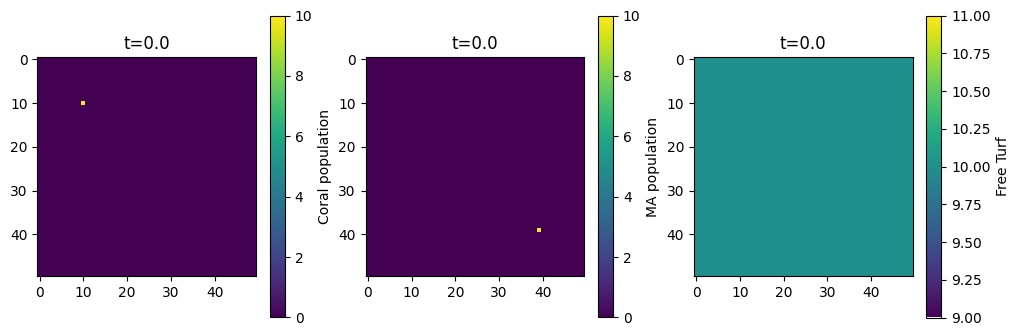

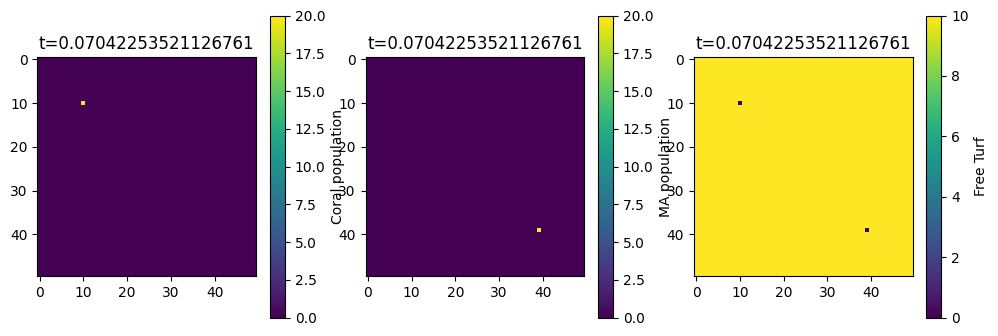

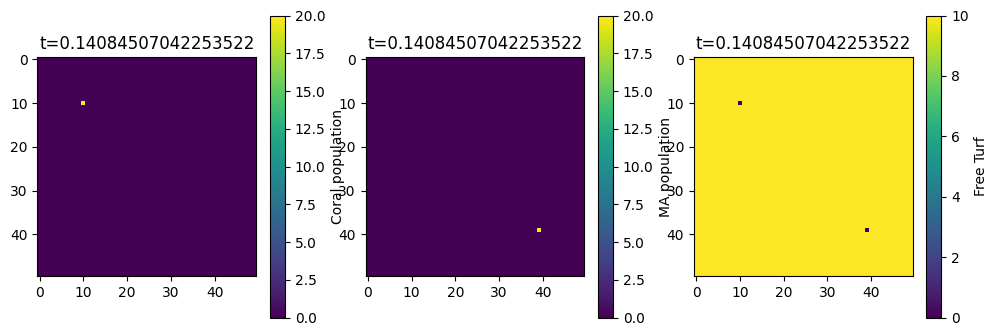

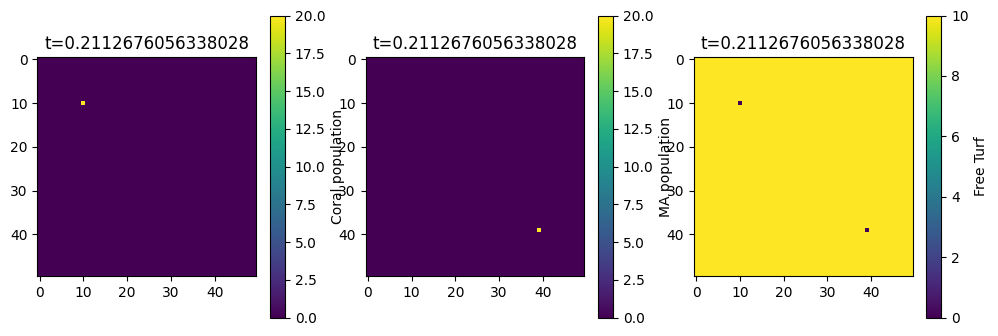

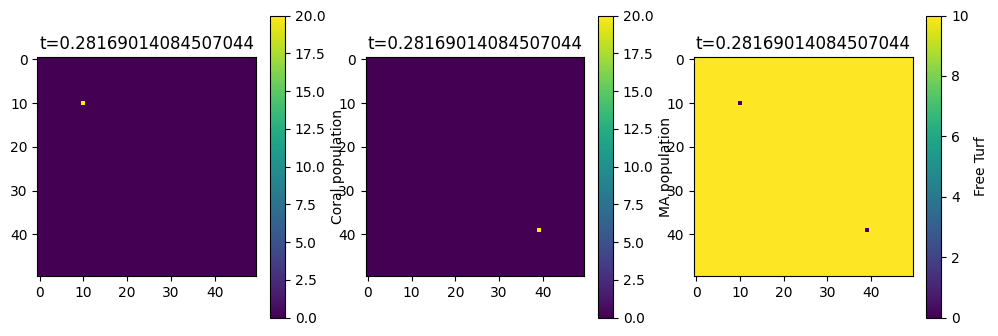

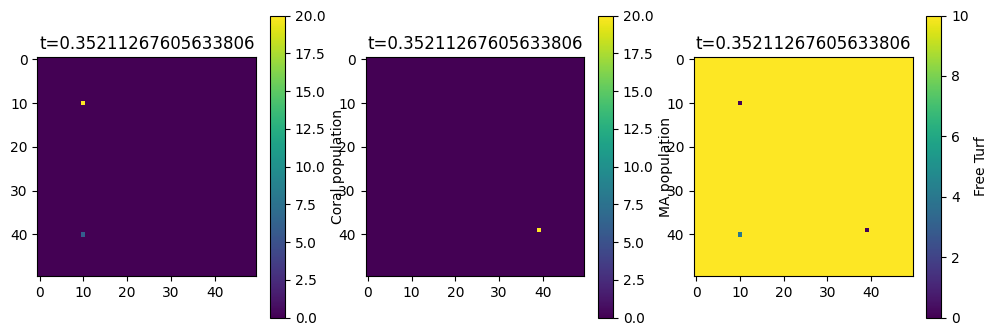

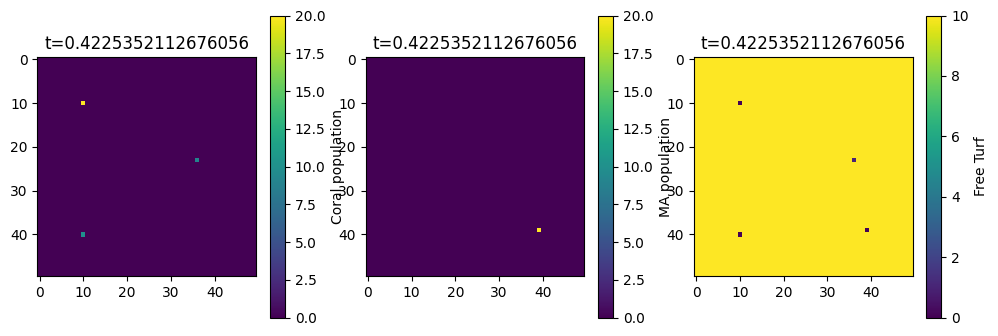

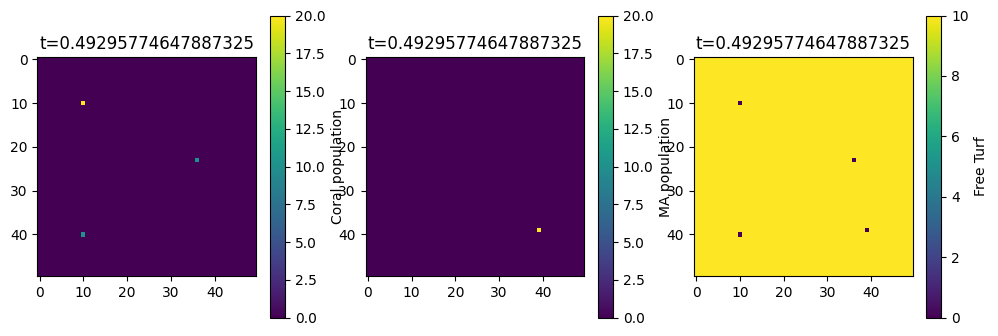

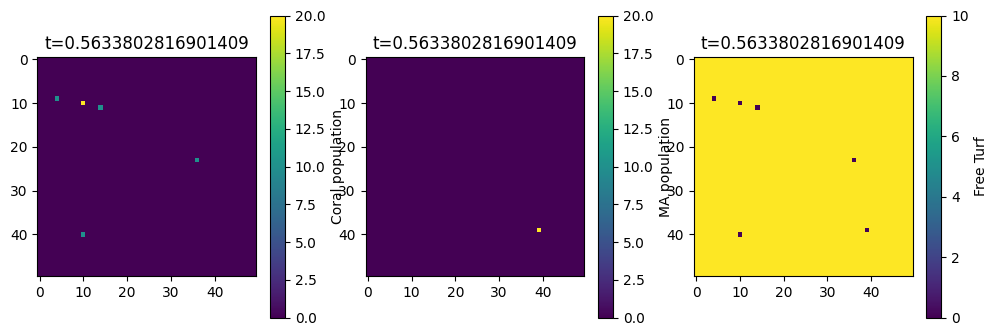

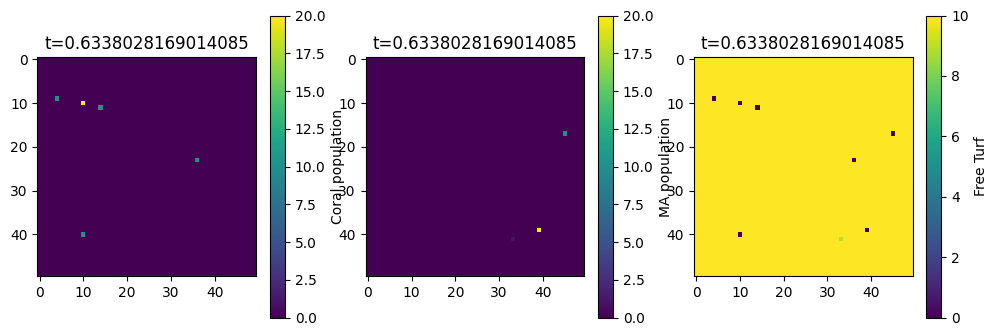

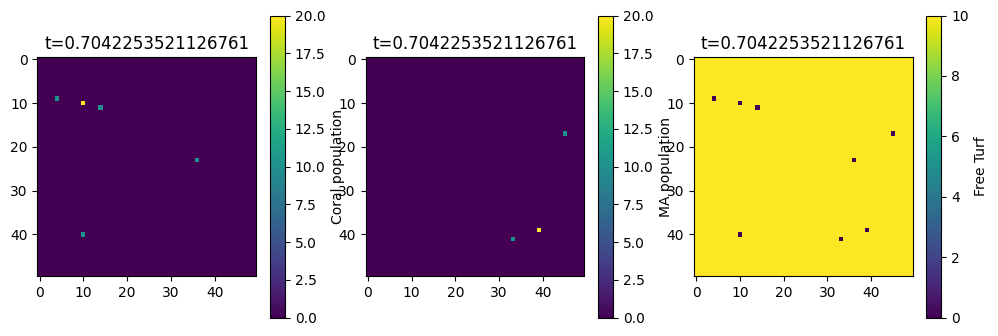

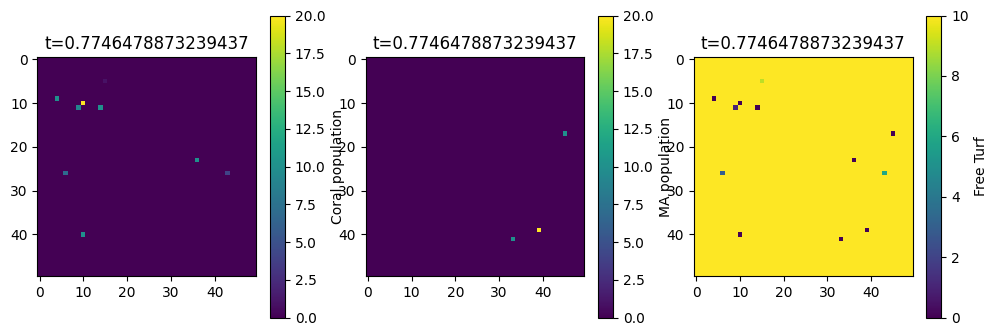

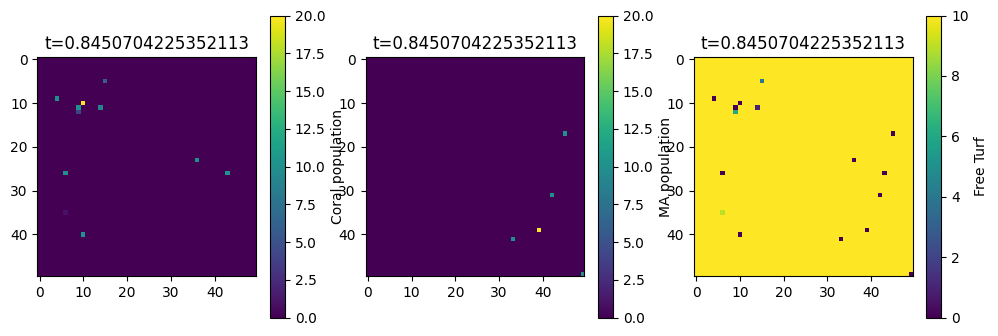

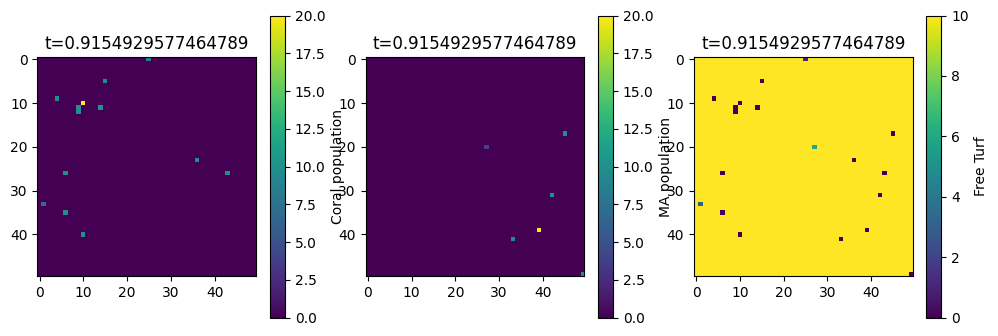

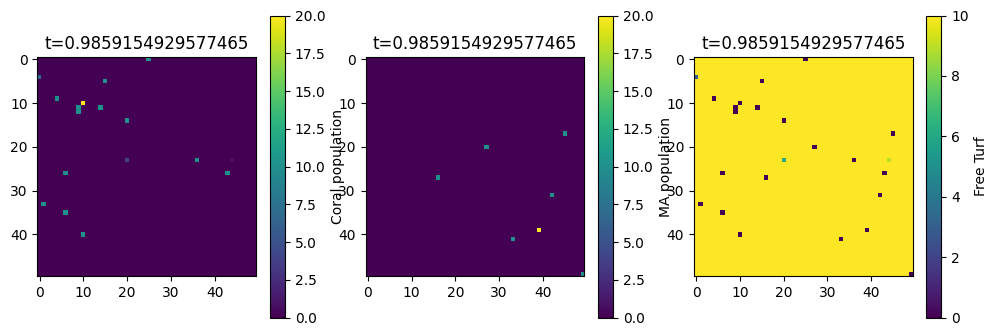

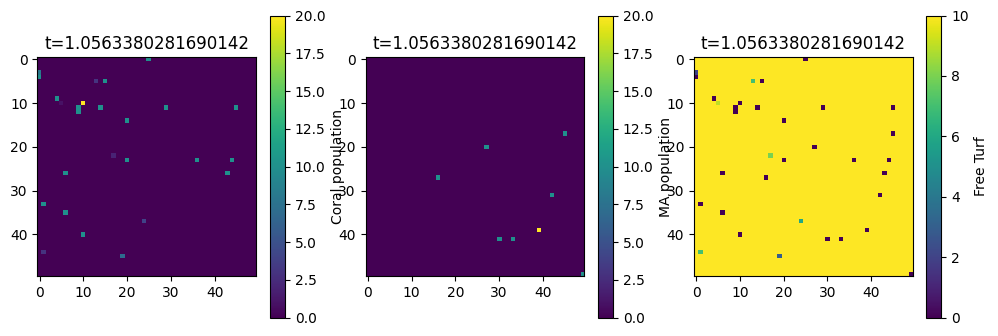

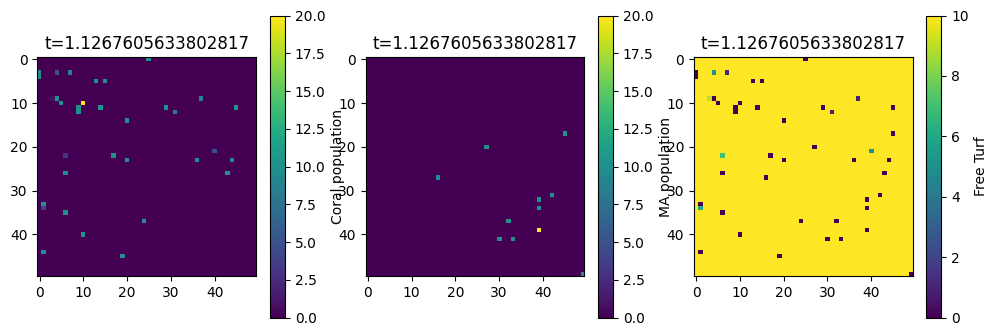

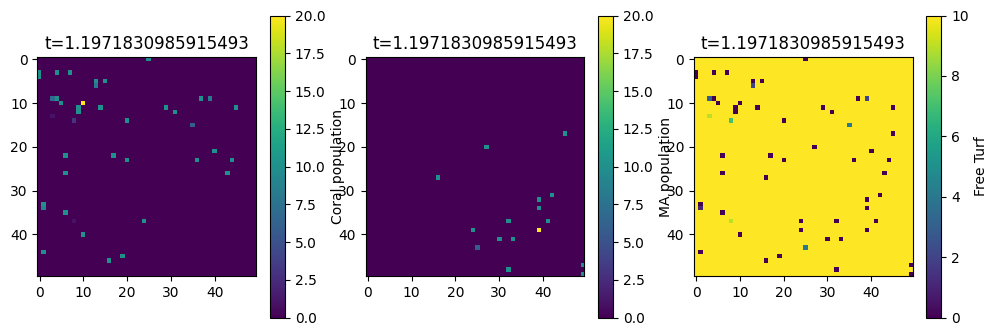

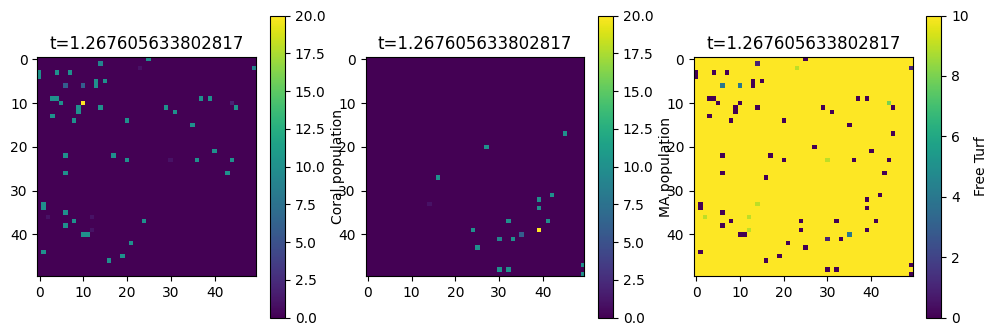

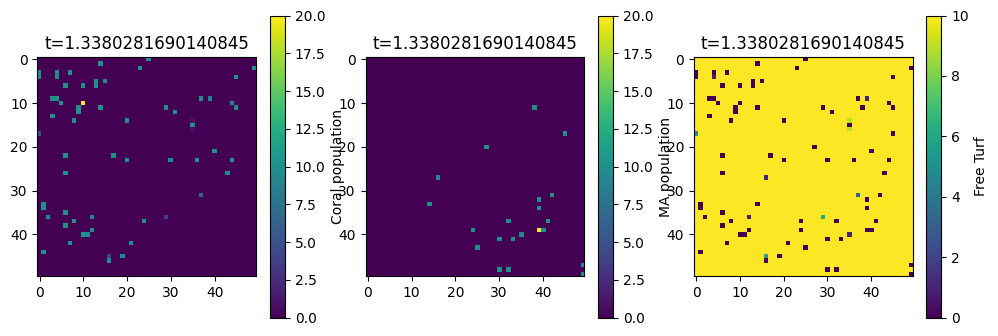

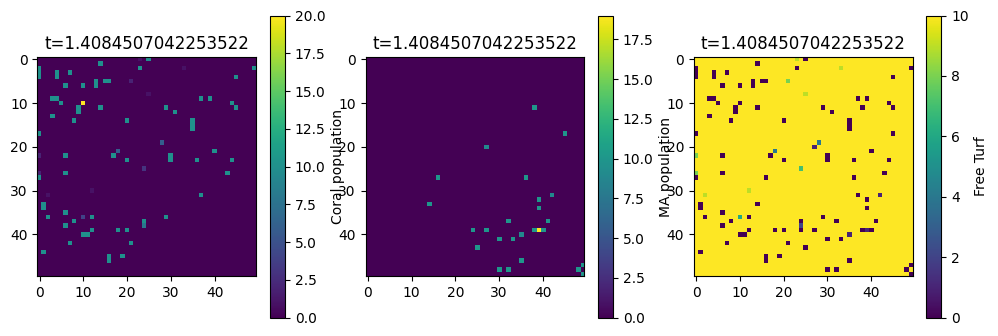

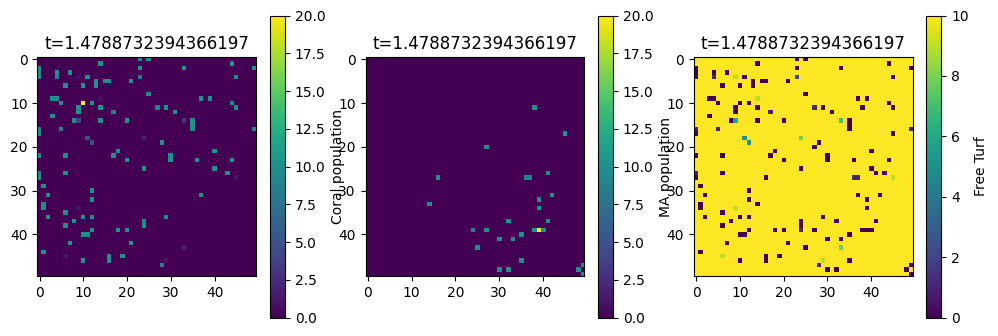

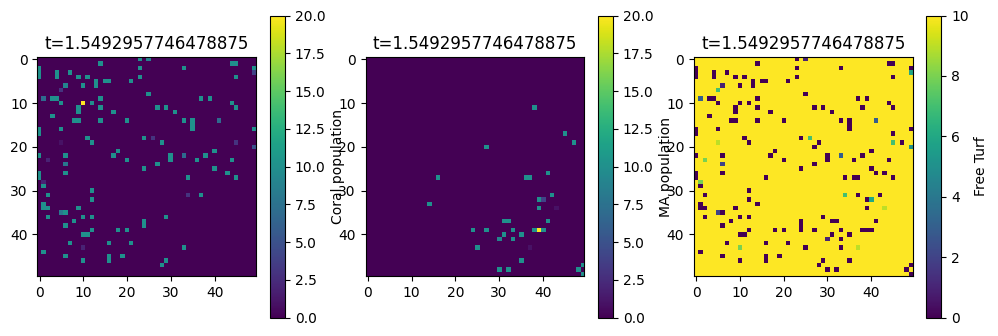

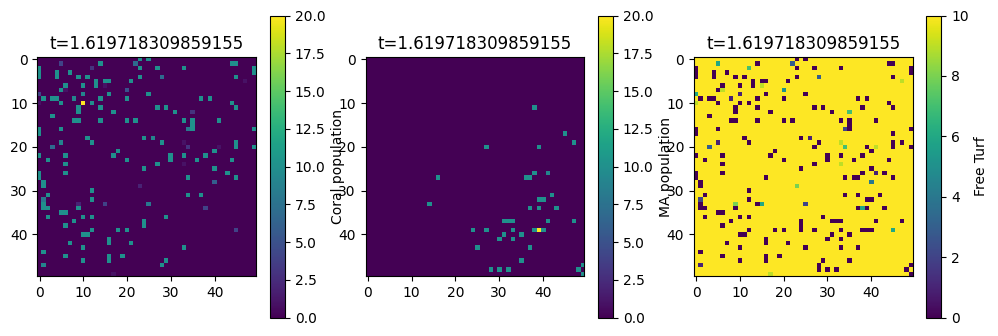

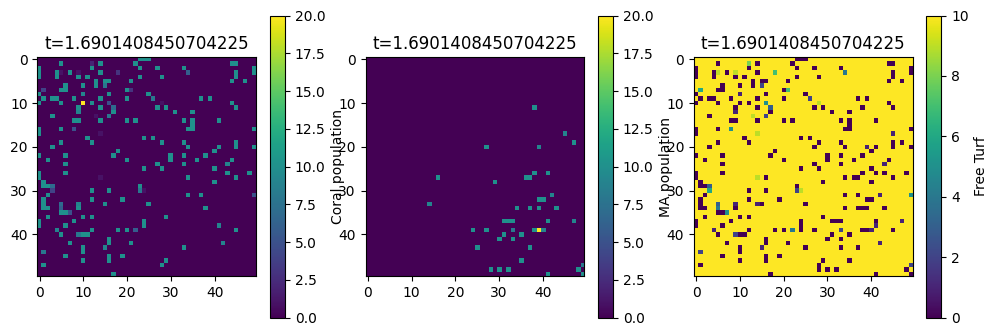

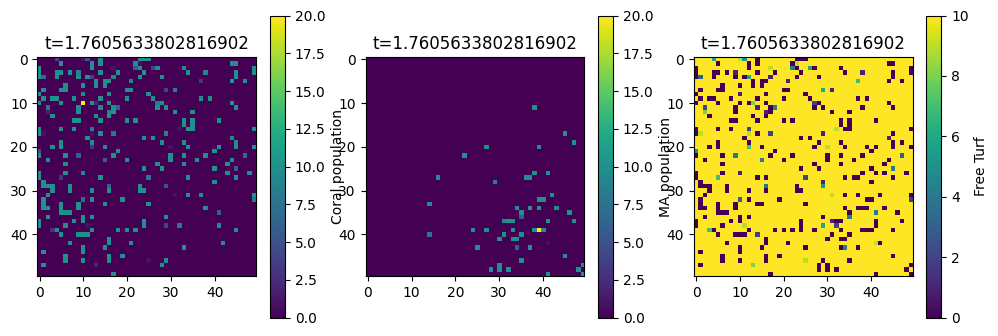

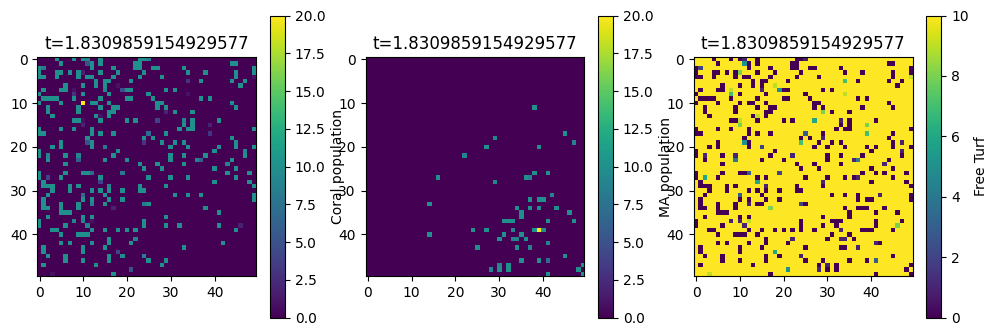

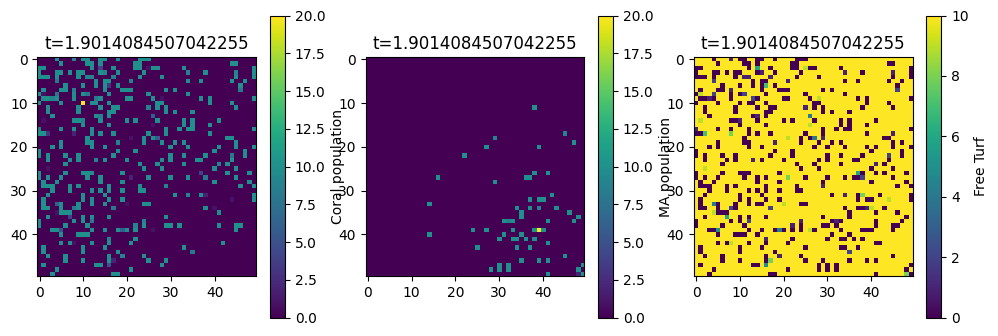

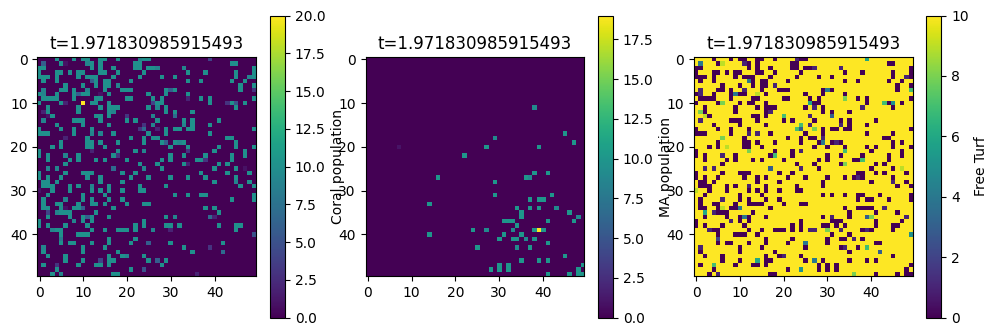

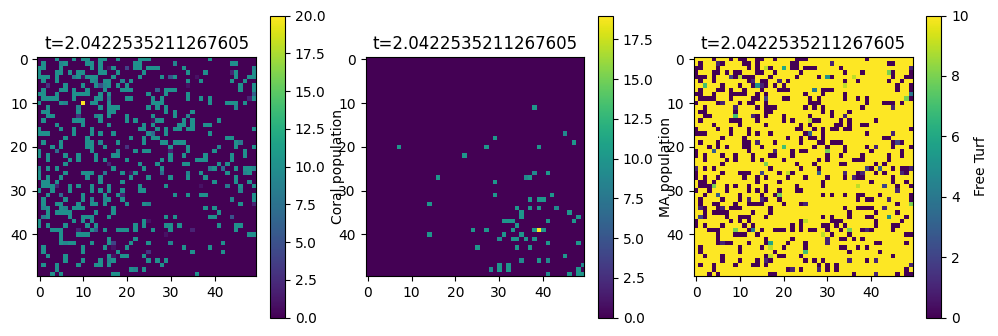

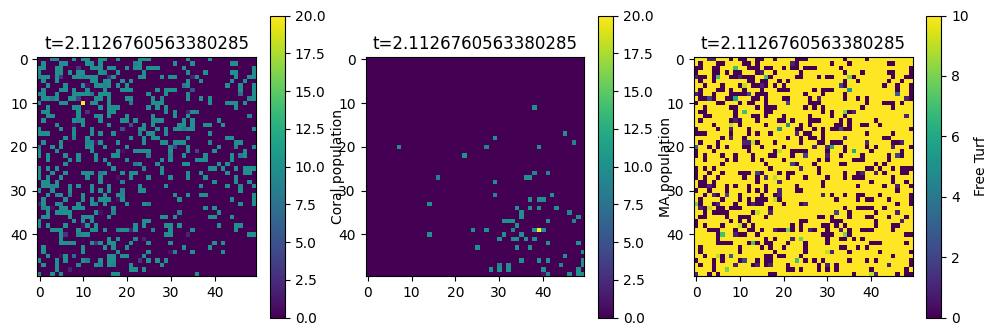

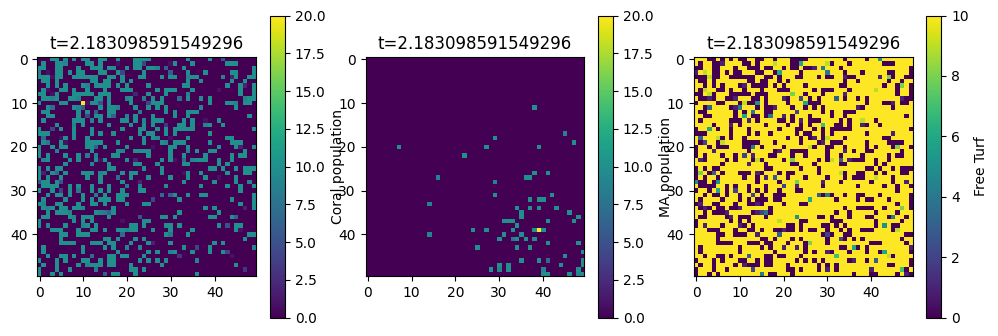

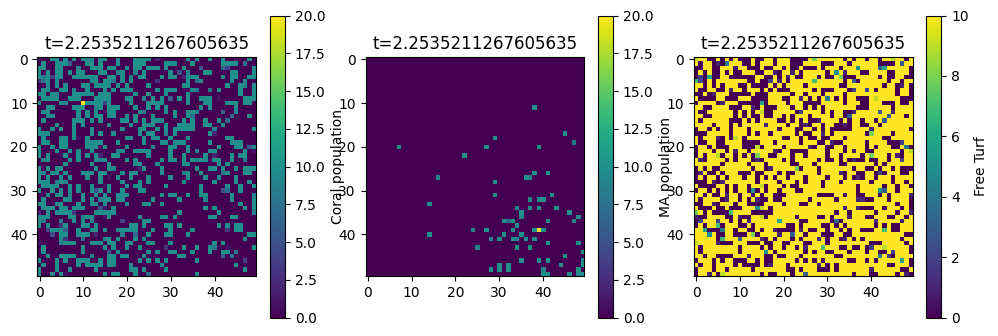

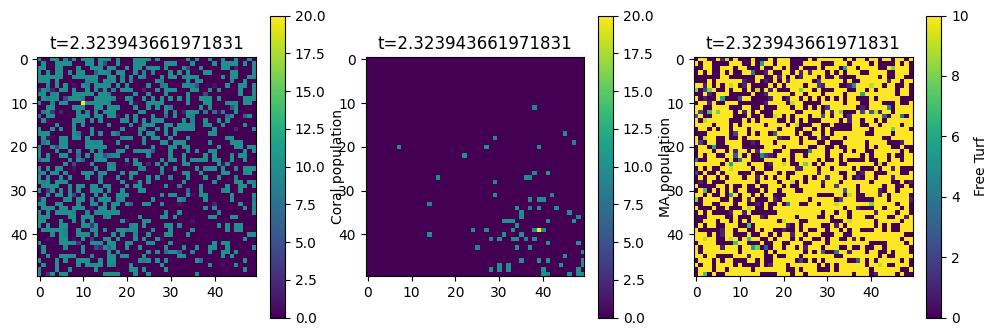

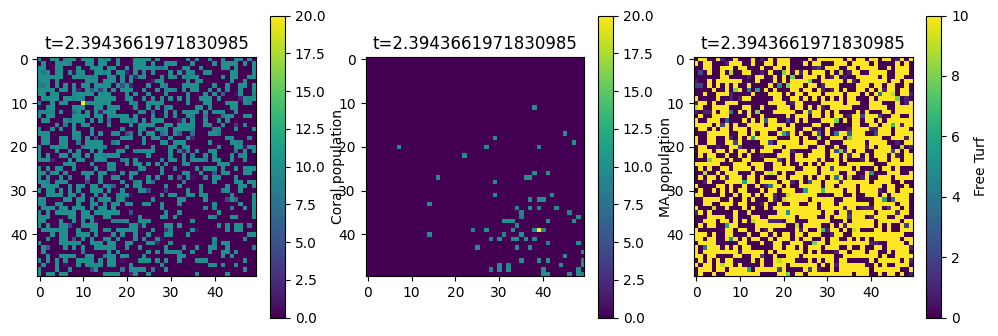

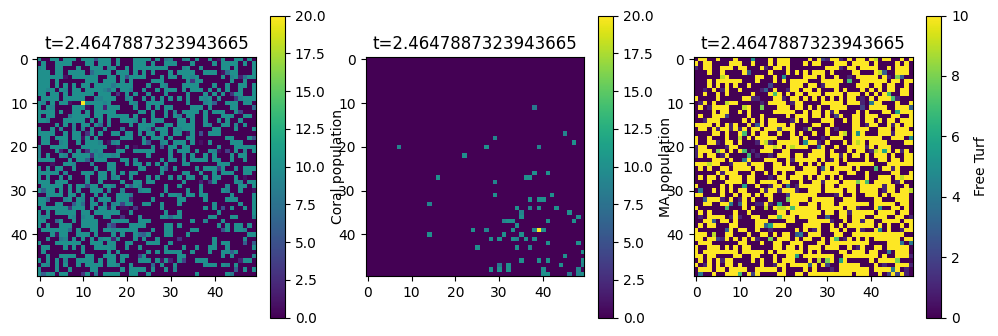

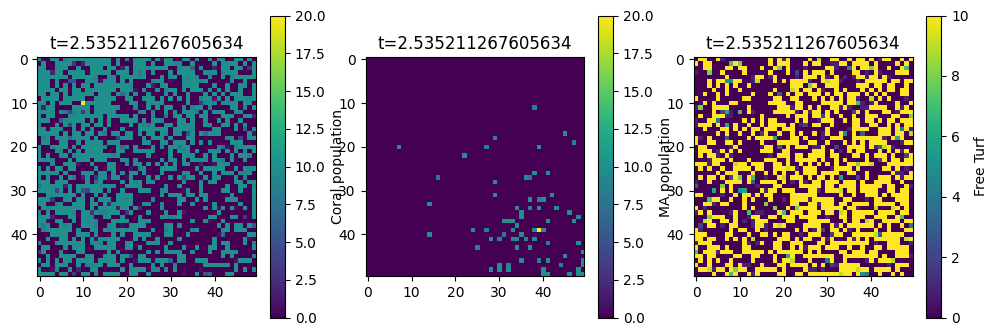

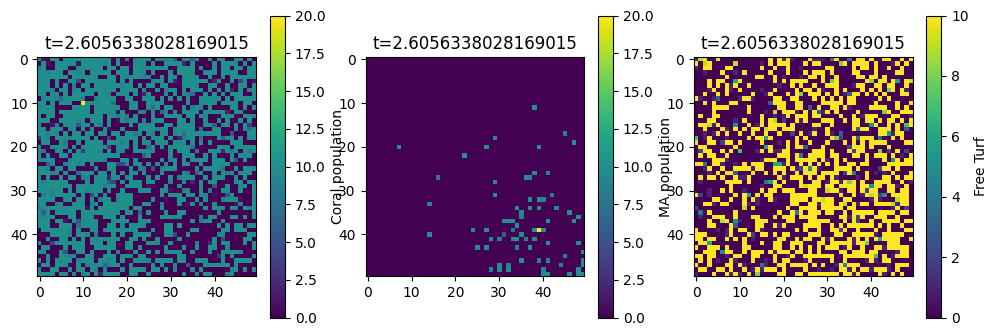

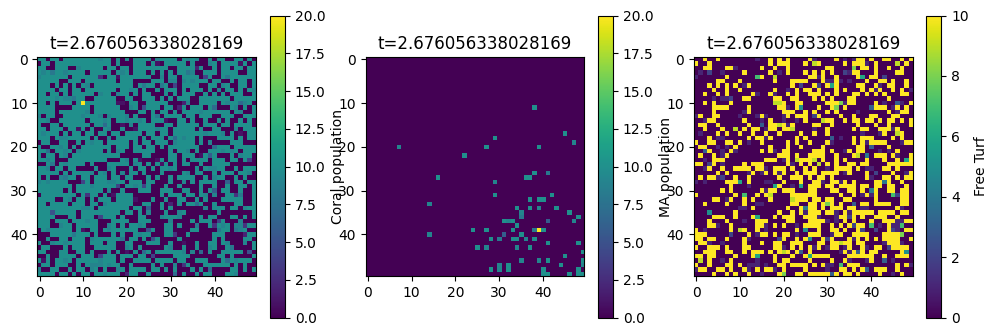

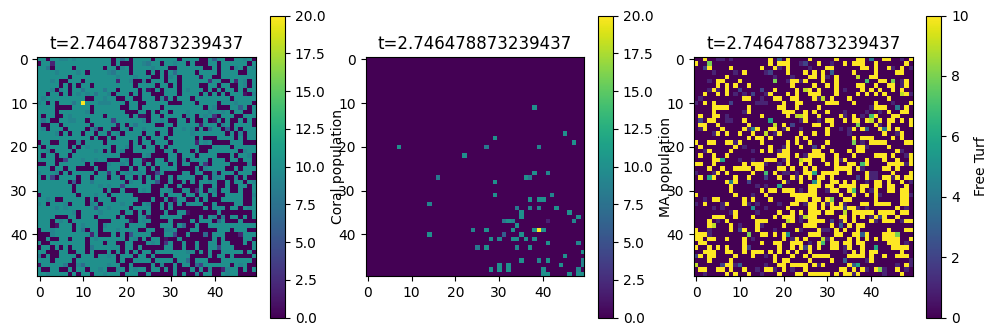

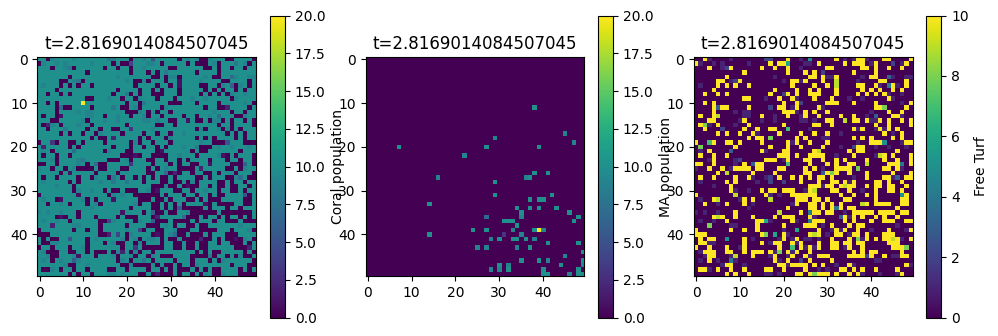

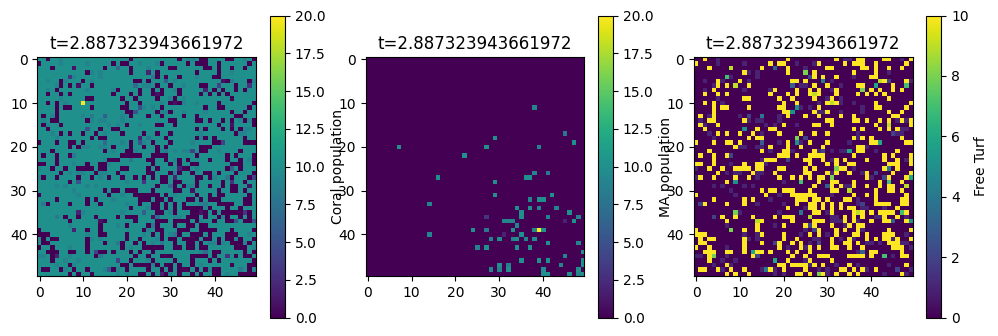

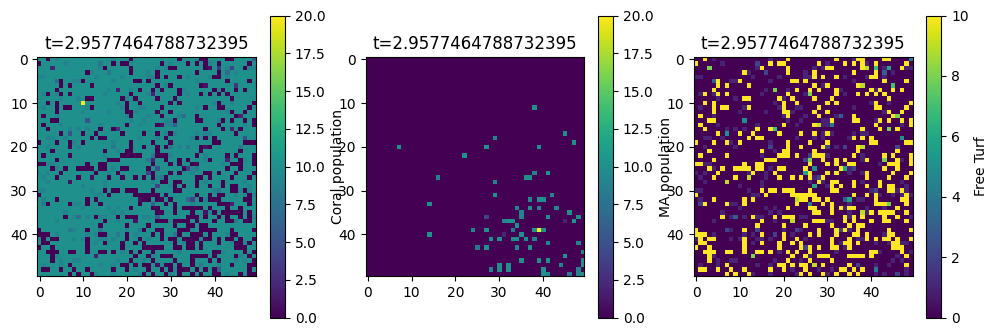

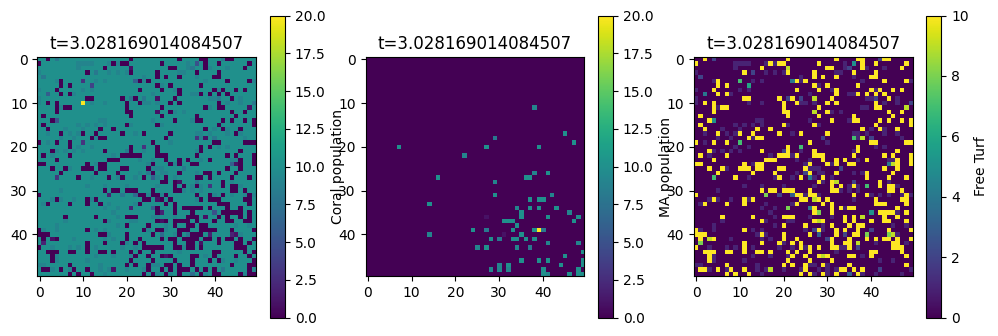

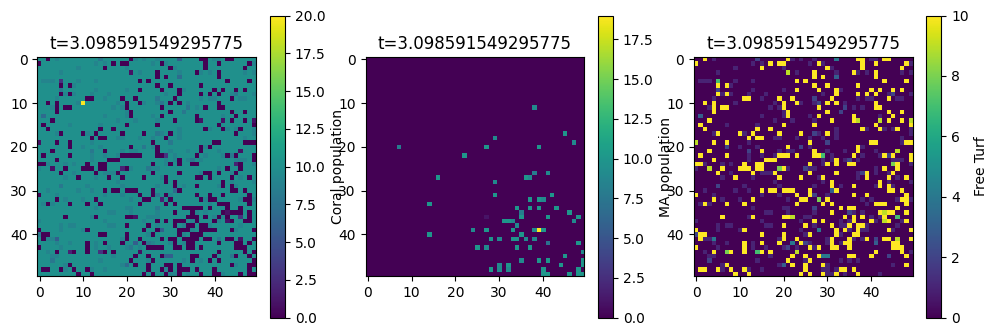

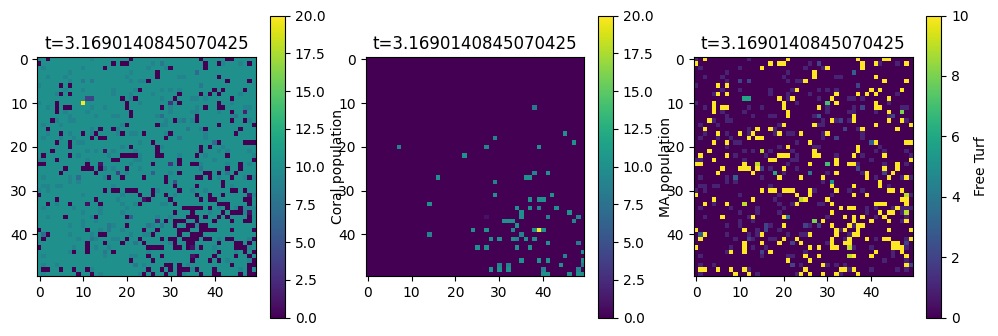

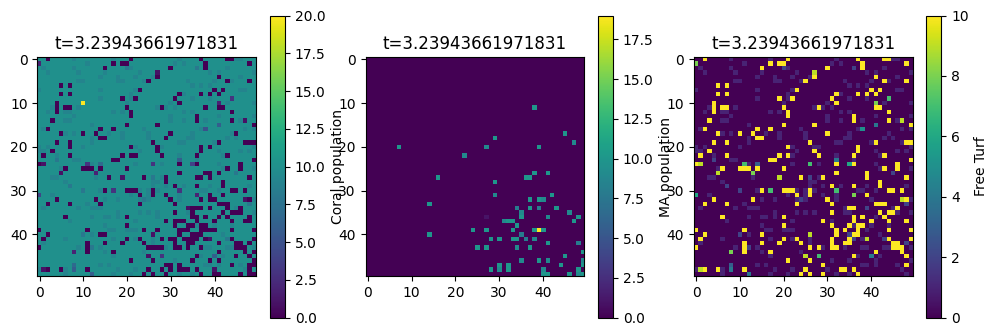

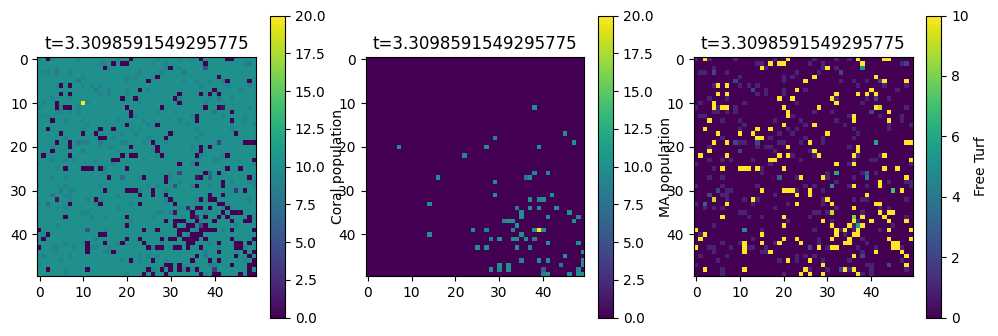

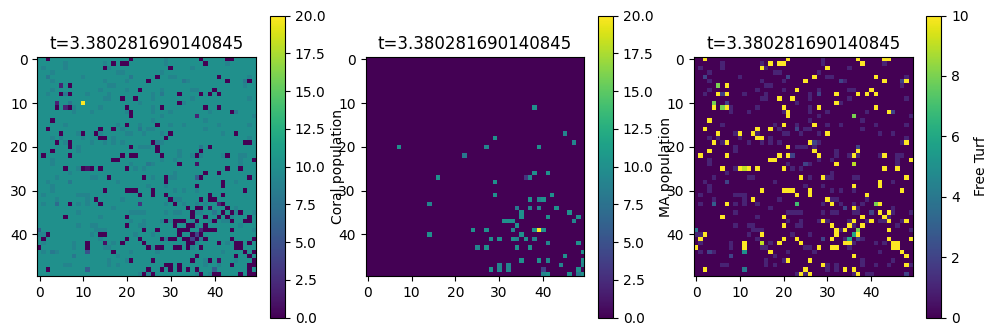

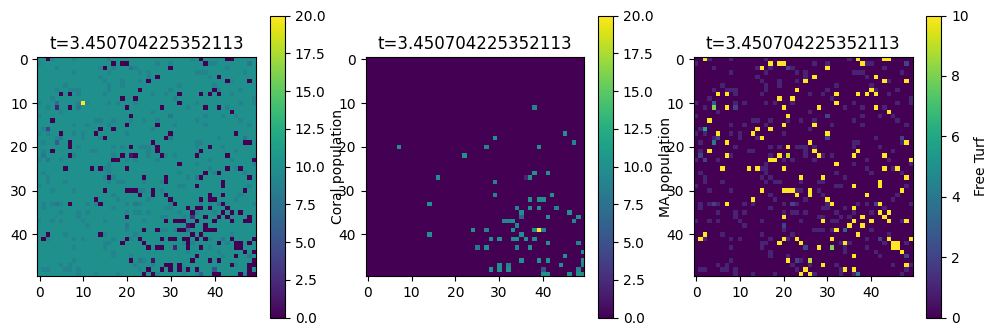

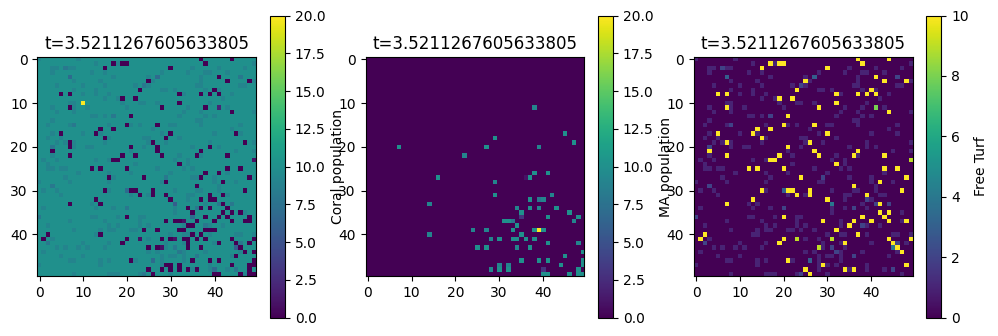

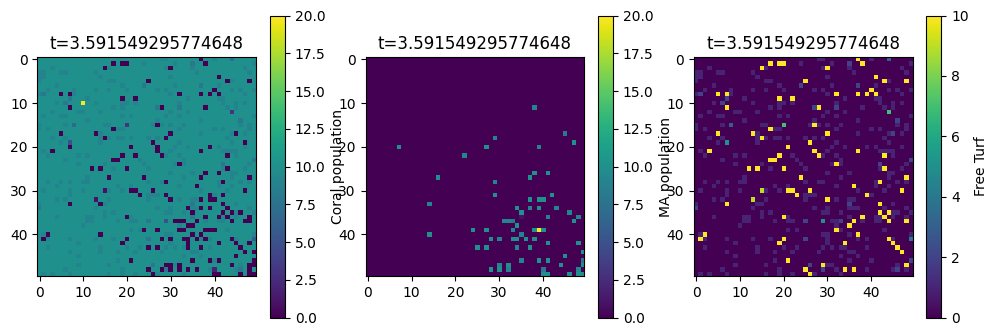

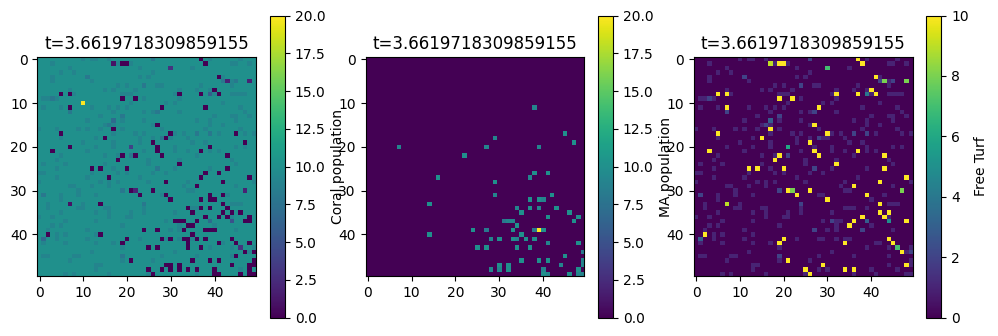

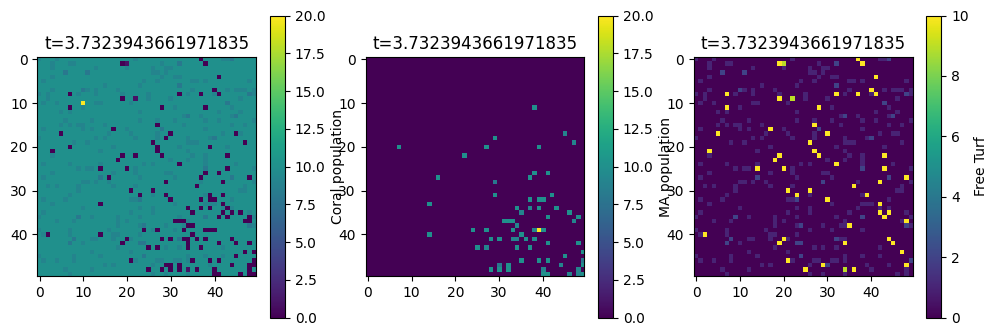

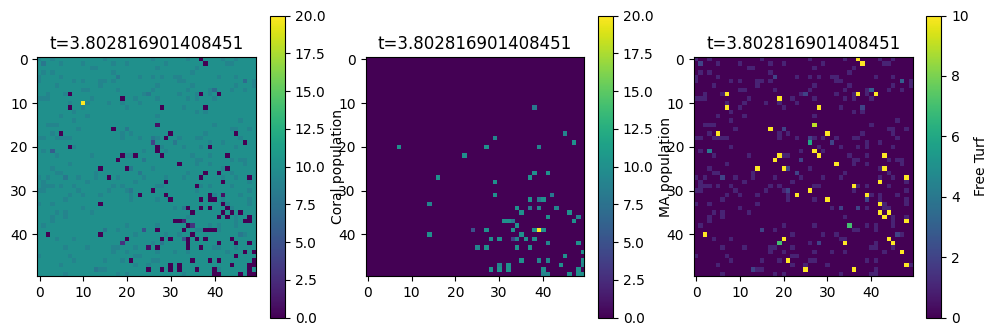

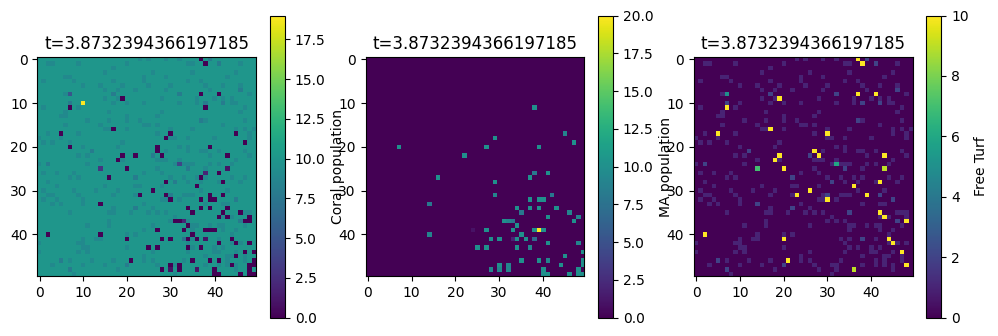

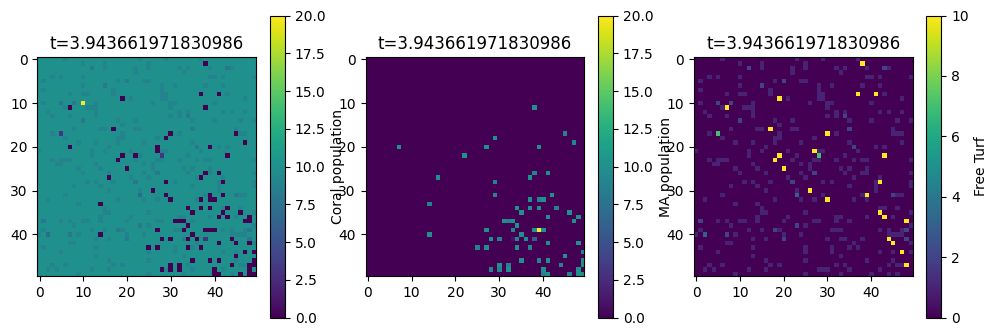

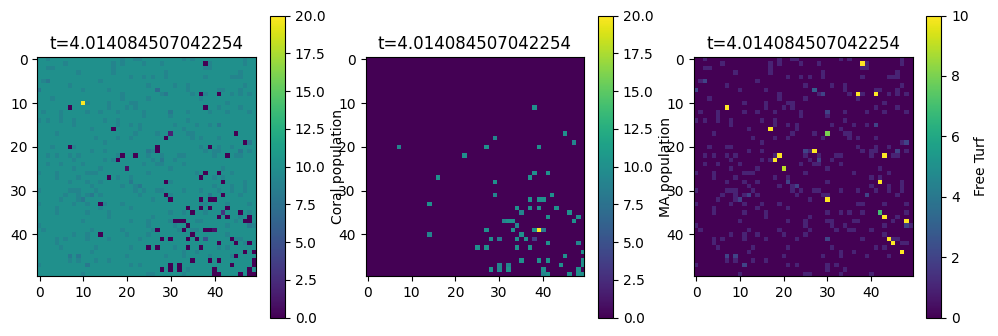

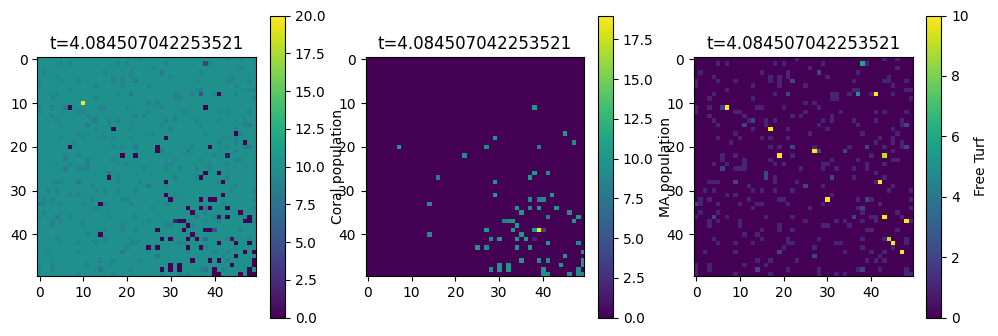

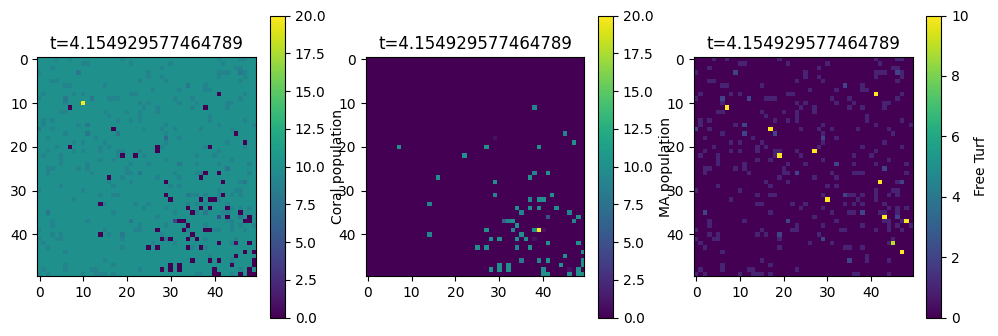

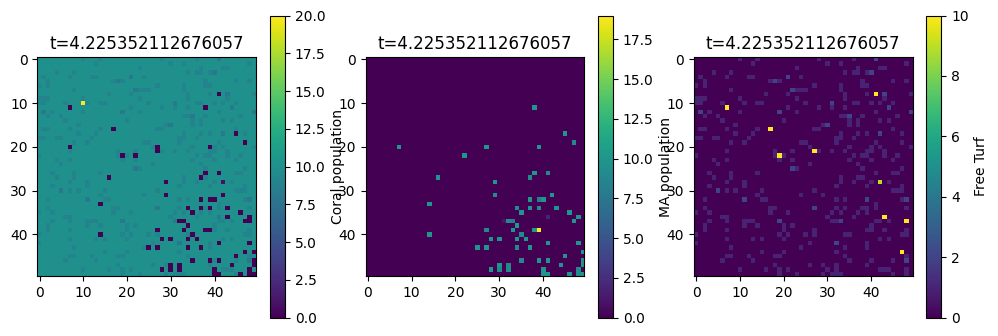

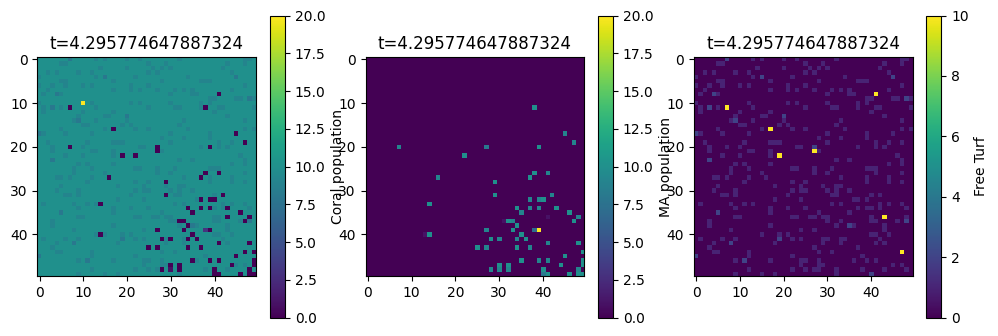

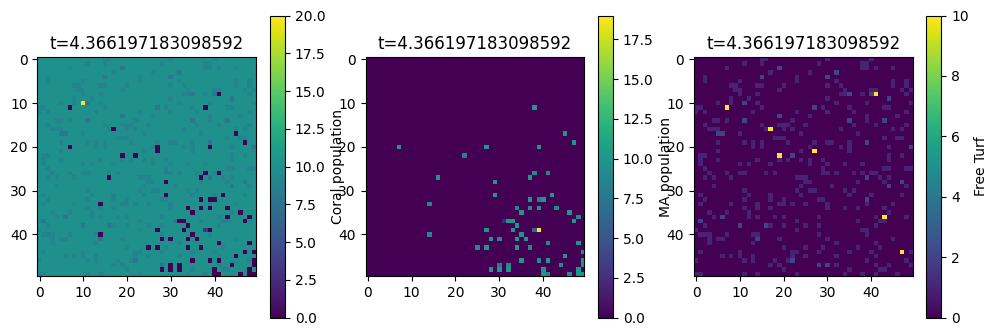

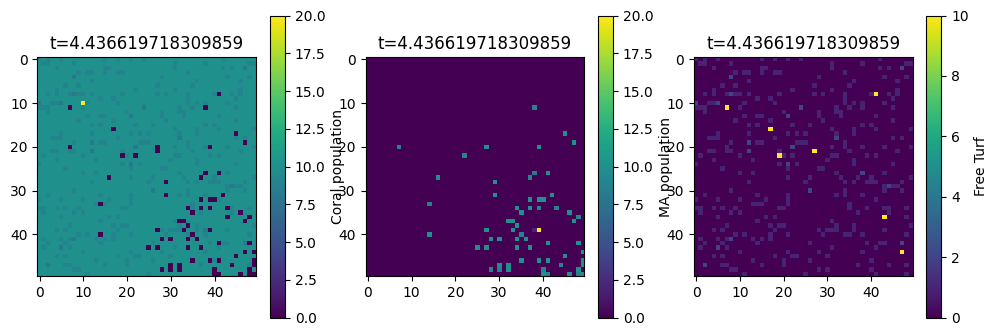

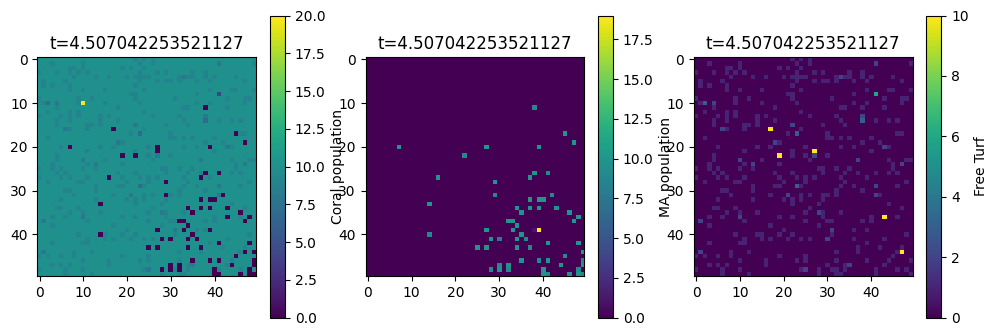

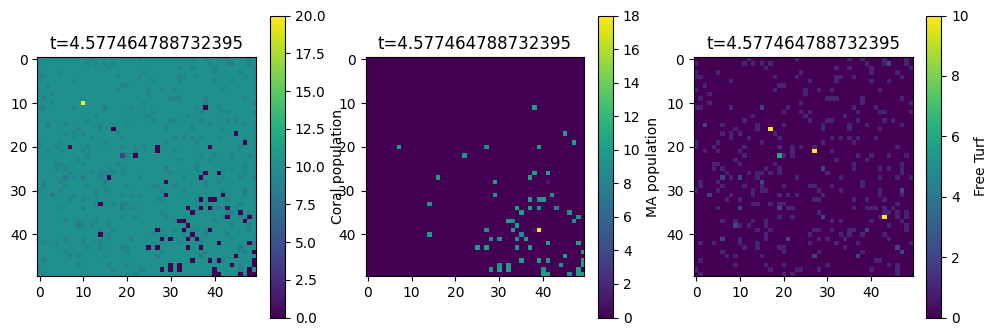

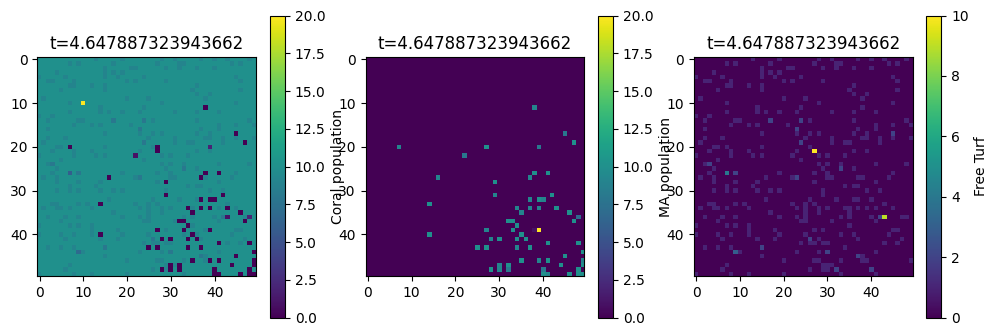

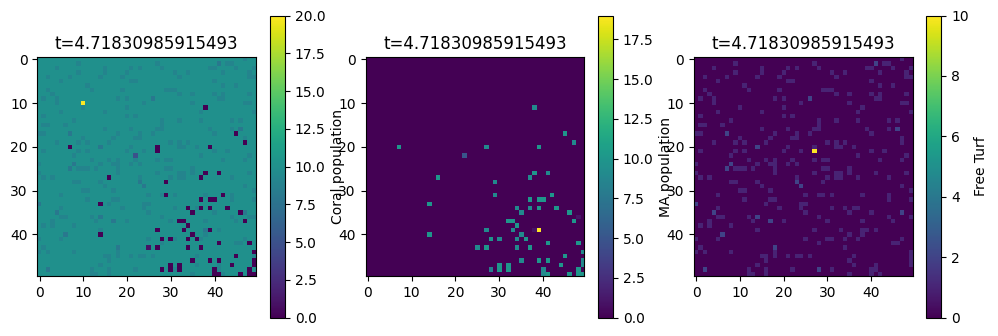

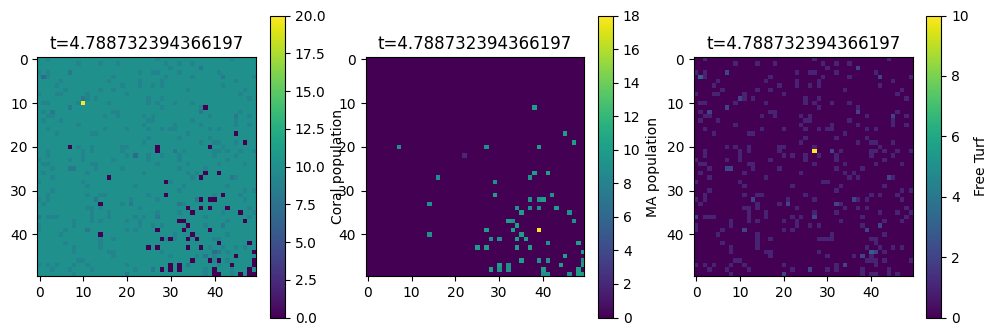

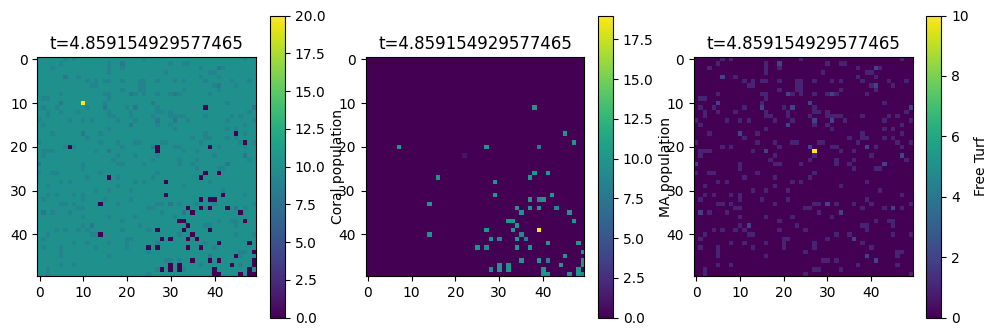

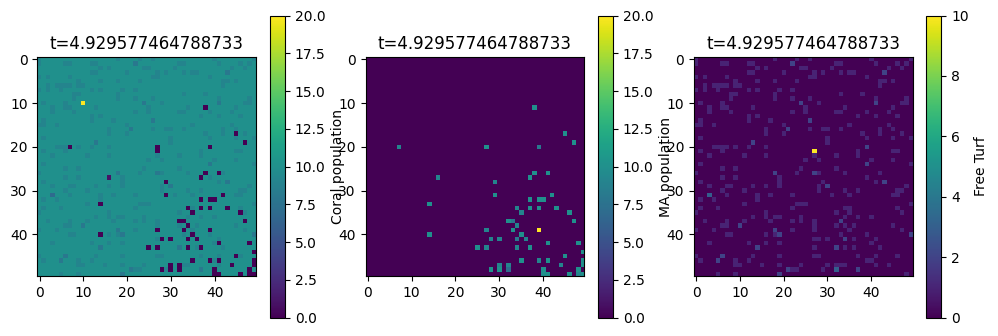

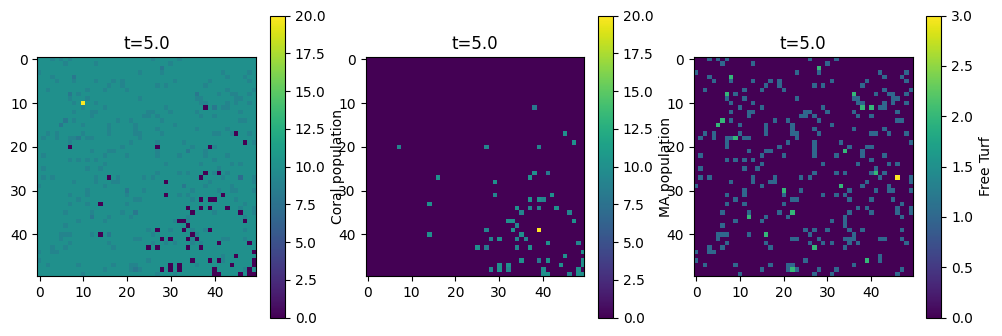

In [8]:
#heatmap
plt.figure(figsize=(12, 6), dpi=100)
plt.figure(1)
for tndx, tval in enumerate(model.tspan):
    plt.figure(figsize=(12, 4), dpi=100)
    plt.subplot(1,3,1)
    heatmap, xedges, yedges = numpy.histogram2d(x=x_vals, y=y_vals, weights=C_vals[tndx,:], bins=int(numpy.sqrt(num_vox)))
    plt.imshow(heatmap)
    cb = plt.colorbar()
    cb.set_label('Coral population')
    plt.title('t={0}'.format(tval))
    plt.subplot(1,3,2)
    heatmap, xedges, yedges = numpy.histogram2d(x=x_vals, y=y_vals, weights=MA_vals[tndx,:], bins=int(numpy.sqrt(num_vox)))
    plt.imshow(heatmap)
    cb = plt.colorbar()
    cb.set_label('MA population')
    plt.title('t={0}'.format(tval))
    plt.subplot(1,3,3)
    heatmap, xedges, yedges = numpy.histogram2d(x=x_vals, y=y_vals, weights=Turf_vals[tndx,:], bins=int(numpy.sqrt(num_vox)))
    plt.imshow(heatmap)
    cb = plt.colorbar()
    cb.set_label('Free Turf')
    plt.title('t={0}'.format(tval))
    plt.show()

## Let's compare to an ODE simulation of well-mixed version of this model.

In [9]:
from scipy.integrate import ode

In [10]:
def par(name):
    return model.listOfParameters[name].value

def coral_ode(t, rp):
    C = rp[0]
    M = rp[1]
    C_m = rp[2]
    M_m = rp[3]
    T = rp[4]
    return [
        par('phi_c') * C_m * T + par('g_tc') * T * C - par('Gamma') * par('g_tm') * M * C - par('dc') * C,
        par('phi_m') * M_m * T + par('g_tm') * T * M + par('Gamma') * par('g_tm') * M * C - par('dm') * M,
        par('R_c') * C - par('mu_c') * C_m - par('alpha_c') * M * C_m,
        par('R_m') * M - par('mu_m') * M_m - par('alpha_m') * C * M_m,
        par('dc') * C + par('dm') * M - par('phi_c') * C_m * T - par('phi_m') * \
                            M_m * T - par('g_tc') * T * C - par('g_tm') * T * M
        ]

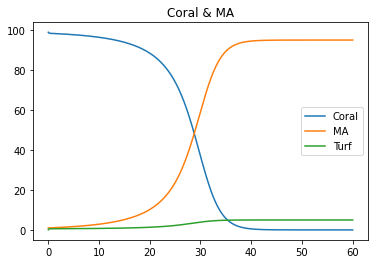

In [11]:
solver = ode(coral_ode).set_integrator('vode', method='bdf', order=15, atol=1e-6)
rp0 = ([99.0, 1.0, 0.0, 0.0, 0.0]) # starting function
solver.set_initial_value(rp0, 0)
T = 60
dt = T/5000.
rp = []; t = []
while solver.successful() and solver.t <= T:
    solver.integrate(solver.t + dt)
    rp.append(solver.y); t.append(solver.t)
    
# Plotting    
rp = numpy.array(rp)
plt.figure()
plt.plot(t, rp[:,  0], t, rp[:, 1], t, rp[:,4])
plt.title("Coral & MA")
plt.legend(['Coral','MA','Turf'])